<a href="https://colab.research.google.com/github/cheng0622/Volume/blob/main/%E5%AE%9A%E6%9C%9F%E5%AE%9A%E9%A1%8D_%E5%9B%9E%E6%B8%AC%E5%9C%96%E8%A1%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.安裝函式庫及中文字體

In [1]:
!pip install yfinance
!apt-get update
!apt-get install -y fonts-noto-cjk

# 強制清除 Matplotlib 字體快取目錄 (這是關鍵步驟，確保字體重新掃描)
# 在 Colab 中，Matplotlib 快取通常位於 /root/.cache/matplotlib
!rm -rf /root/.cache/matplotlib

# 設定 matplotlib 使用新的中文字體
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 注意：在清除快取後，這裡的設置會在下次執行時生效。但最保險的做法是重新啟動運行時。
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] # 使用安裝的字體
plt.rcParams['axes.unicode_minus'] = False # 確保負號顯示正常

print("中文字體安裝完成，並已清除 Matplotlib 快取。請務必 '重新啟動運行時 (Restart Runtime)' 後，再依序執行字體安裝儲存格和繪圖儲存格。")

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

2.檢測字體

In [2]:
import matplotlib.font_manager as fm

# 列出所有可用的字體家族，並篩選包含 'Noto Sans CJK' 的字體
font_families = [f.name for f in fm.fontManager.ttflist if 'Noto Sans CJK' in f.name]

print("Matplotlib 偵測到的 'Noto Sans CJK' 相關字體：")
if font_families:
    for font_name in font_families:
        print(f"- {font_name}")
else:
    print("未偵測到 'Noto Sans CJK' 相關字體。請確認字體已正確安裝並重新啟動運行時。")

# 另外，檢查 Matplotlib 配置中實際使用的 sans-serif 字體
import matplotlib.pyplot as plt
print(f"\nMatplotlib 當前 sans-serif 設定為: {plt.rcParams['font.sans-serif']}")

Matplotlib 偵測到的 'Noto Sans CJK' 相關字體：
- Noto Sans CJK JP
- Noto Sans CJK JP

Matplotlib 當前 sans-serif 設定為: ['Noto Sans CJK JP']


3.回測

/tmp/ipython-input-1925829629.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


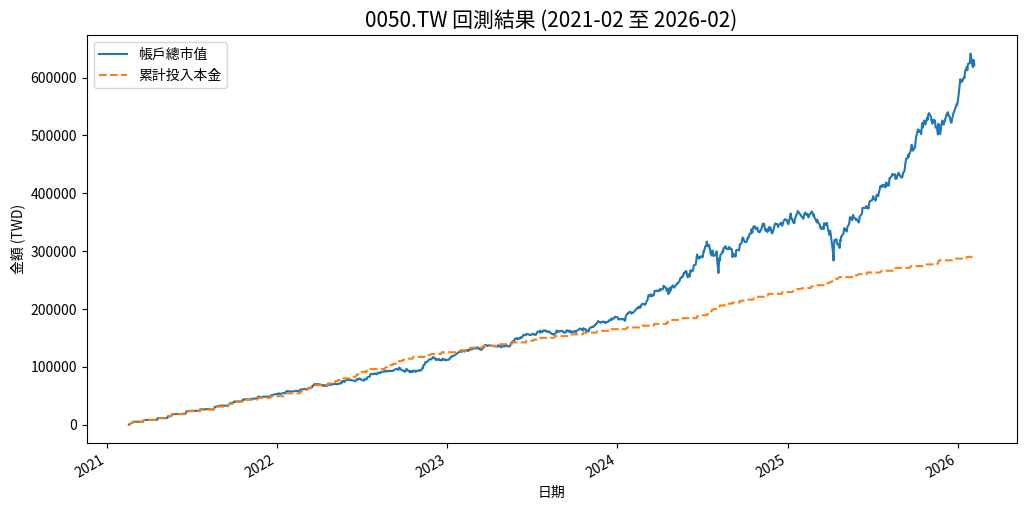

【0050.TW 過去 5 年回測結果】
 總投入本金: 290,000 元
 最終資產市值: 621,079 元
 累計報酬率: 114.17%


In [5]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# 1. 初始條件
stock = "0050.TW"    # 股票代號 (台股加 .TW)
backtest_year = 5       # 回測年數
monthly_date = 20           # 每月定投日期
monthly_amount = 3000       # 定投金額
dip_trigger_pct = -0.02     # 加碼趴數
dip_amount = 2000           # 加碼金額

# 2. 獲取數據與初始化
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=backtest_year * 365)
data = yf.download(stock, start=start_date, end=end_date)

total_investment = 0.0
total_shares = 0.0
daily_portfolio_values = []
investment_steps = []

# 3. 逐日模擬邏輯
for i in range(len(data)):
    current_date = data.index[i] #抓出今日日期
    open_price = data['Open'].iloc[i].item() #抓今日開盤價轉浮點數
    close_price = data['Close'].iloc[i].item() #收盤價
    prev_close = data['Close'].iloc[i-1].item() if i > 0 else close_price #抓昨日收盤價算今日漲跌幅

    # A定期定額 (處理假日順延)
    # 判斷是否為每月定期定額日期之後的第一個交易日
    is_first_trading_after_target = False
    if current_date.day >= monthly_date:
        if i == 0:
            is_first_trading_after_target = True
        else:
            if data.index[i-1].day < monthly_date:
                is_first_trading_after_target = True

    if is_first_trading_after_target:
        total_shares += monthly_amount / open_price
        total_investment += monthly_amount

    # B自定義跌幅加碼
    daily_return = (close_price - prev_close) / prev_close #漲跌幅
    if daily_return <= dip_trigger_pct:
        total_shares += dip_amount / close_price
        total_investment += dip_amount

    # 紀錄每日狀態
    daily_portfolio_values.append(total_shares * close_price)
    investment_steps.append(total_investment)

# 4. 結果輸出與繪圖 (自動適應時間軸)
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] # 換中文字體
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 6))
plt.plot(data.index, daily_portfolio_values, label='帳戶總市值', color='#1f77b4')
plt.plot(data.index, investment_steps, label='累計投入本金', color='#ff7f0e', linestyle='--')
start_str = data.index[0].strftime('%Y-%m')
end_str = data.index[-1].strftime('%Y-%m')
plt.title(f'{stock} 回測結果 ({start_str} 至 {end_str})', fontsize=15)
plt.xlabel('日期')
plt.ylabel('金額 (TWD)')
plt.legend()
plt.grid(True, alpha=0)
plt.gcf().autofmt_xdate()
plt.show()

final_value = daily_portfolio_values[-1]
roi = (final_value - total_investment) / total_investment * 100

print(f"【{stock} 過去 {backtest_year} 年回測結果】")
print(f" 總投入本金: {total_investment:,.0f} 元")
print(f" 最終資產市值: {final_value:,.0f} 元")
print(f" 累計報酬率: {roi:.2f}%")